In [1]:
from pathlib import Path

import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.schemas import NlpContext
from torchlake.sequence_data.models import LstmClassifier
from torchtext.datasets import CoNLL2000Chunking
from torchlake.common.utils.text import build_vocab
from tqdm import tqdm

# setting


In [2]:
data_path = Path("../../data/CoNLL2000")
artifacts_path = Path("../../artifacts/bilstm")

In [3]:
batch_size = 128
context = NlpContext()

# data


In [4]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda item: [[word.lower() for word in item[0]], item[1]]
    ).filter(lambda item: len(item[0]) > context.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [5]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [6]:
vocab = build_vocab(map(lambda it: it[0], train_data))
label_vocab = build_vocab(map(lambda it: it[1], train_data))

In [7]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [8]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [9]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [10]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


# model


In [11]:
vocab_size = len(vocab)
label_size = len(label_vocab)

In [12]:
device = torch.device(context.device)

In [13]:
model = LstmClassifier(
    vocab_size,
    128,
    128,
    label_size,
    bidirectional=True,
    context=context,
    is_sequence=True,
).to(device)

In [14]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LstmClassifier                           --
├─Embedding: 1-1                         563,968
├─LSTM: 1-2                              264,192
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            12,336
Total params: 841,008
Trainable params: 841,008
Non-trainable params: 0

# train


In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=context.padding_idx)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [16]:
model.train()
for epoch in range(10):
    running_loss = 0.0

    dataset_count = 0
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text).permute(0, 2, 1)
        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        dataset_count += text.size(0)

    print(f"epoch {epoch+1}: {running_loss/dataset_count}")

67it [00:07,  9.23it/s]


epoch 1: 0.022630995195080984


67it [00:04, 15.20it/s]


epoch 2: 0.016153694936699832


67it [00:04, 16.10it/s]


epoch 3: 0.014119819793572177


67it [00:04, 16.28it/s]


epoch 4: 0.012886879854460262


67it [00:04, 15.39it/s]


epoch 5: 0.012007282254522416


67it [00:04, 16.63it/s]


epoch 6: 0.011335436185238077


67it [00:04, 16.20it/s]


epoch 7: 0.010797563259170126


67it [00:04, 16.22it/s]


epoch 8: 0.010353772720294212


67it [00:04, 16.14it/s]


epoch 9: 0.009983296283701463


67it [00:04, 15.23it/s]

epoch 10: 0.009664265730821374


# inference


In [17]:
evaluator = ClassificationEvaluator(label_size, device)

In [18]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)
    for text, label in tqdm(train_iter):
        text = text.to(device)

        output = model(text).argmax(dim=2)

        confusion_matrix.update(
            label.view(-1).numpy(),
            output.view(-1).detach().cpu().numpy(),
        )

    print(confusion_matrix)

67it [00:06, 11.07it/s]

[[   0    0    0 ...    0    0    0]
 [   0 8576    0 ...    0    0    0]
 [   0    0 8576 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [19]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 1.0
<pad>     : 0.0
NN        : 0.7329493785995757
IN        : 0.9125673329475137
NNP       : 0.772617642530918
DT        : 0.9318144113255544
NNS       : 0.2450519082829188
JJ        : 0.1636010865347303
,         : 1.0
.         : 0.990086307441101
CD        : 0.45897028249969424
VBD       : 0.4926315789473684
RB        : 0.2109169630431421
VB        : 0.48472058078676344
CC        : 0.9532868713505368
TO        : 0.9998006776958341
VBN       : 0.07672579611027998
VBZ       : 0.5518453427065027
PRP       : 0.7023206188316885
VBG       : 0.00030959752321981426
VBP       : 0.4578313253012048
MD        : 0.5553990610328638
PRP$      : 0.6252019386106623
POS       : 0.92573402417962
$         : 0.9856156501726122
``        : 0.9815059445178336
''        : 0.9824442943956786
:         : 0.30697190426638915
WDT       : 0.05951115834218916
JJR       : 0.07337278106508875
WP        : 0.5684007707129094
WRB       : 0.0
NNPS      : 0.0
JJS       : 0.

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:63: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [31]:
per_class_acc.mean()

0.4000459422865499

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:82: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


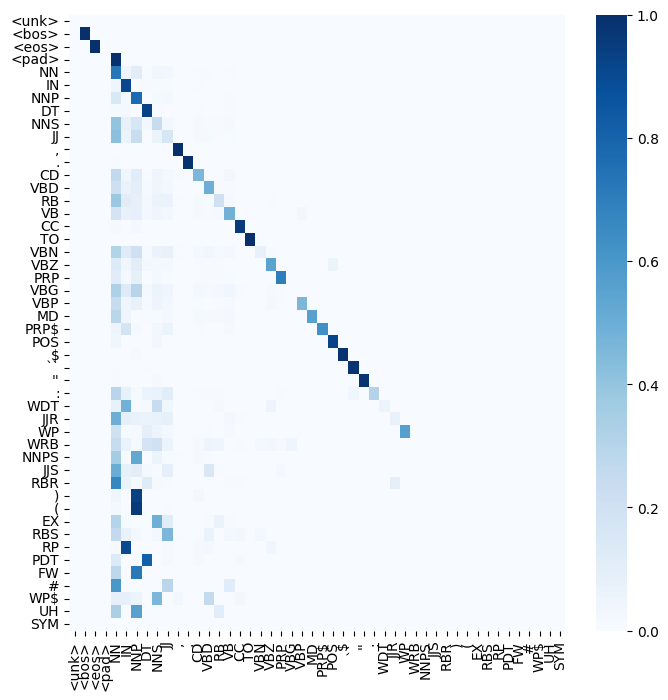

In [21]:
evaluator.plot_confusion_matrix(confusion_matrix, label_vocab.get_itos(), 'Blues', annot=False, figsize=(8, 8))


In [22]:
model_path = artifacts_path / 'bilstm.pth'

In [23]:
torch.save(model.state_dict(), model_path.as_posix())

In [24]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>